In [1]:
# Наш продукт - лента новостей. Планируется внедрить новые алгоритмы рекомендации постов. Чтобы выбрать, какой из алгоритмов будет основным, 
# проведем AB-тест.
# Эксперимент проходил  с 2022-01-28 по 2022-02-03 включительно. Для эксперимента были задействованы 0 и 1 группы.  
# В 1 группе был использован новый алгоритм рекомендации постов, 0 группа использовалась в качестве контроля. 
# Основная гипотеза заключается в том, что новый алгоритм в 1 группе приведет к увеличению CTR. 
# Проанализируем данные АB-теста.

In [2]:
# Нулевая гипотеза формулируется так: CTR в группе 0 равняется CTR в группе 1. Выберем порог alpha равным 0.05.
# Тогда при многократном сравнении пользователей из 1 и 2 мы должны получать статистически значимые различия не чаще, чем в 5 процентов случаев. 
# Чтобы использовать тесты, применимые к данным с нормальным распределением, используем не  сtr, а smothed_ctr.

In [3]:
import seaborn as sns
import pandahouse 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import TTestIndPower
import hashlib
from scipy import stats
%matplotlib inline

In [4]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [5]:
q = """Select user_id,
exp_group,
countIf(action='like') likes,
countIf(action='view') views,
likes/ views ctr
From simulator_20220120.feed_actions
where toDate(time)>='2022-01-28' and toDate(time) <='2022-02-03' and
exp_group in (0, 1)
group by user_id, exp_group
"""

df = pandahouse.read_clickhouse (q, connection=connection)

In [6]:
mean_ctr_0 = df[df.exp_group ==0].ctr.mean()
mean_ctr_0

0.22195492956578466

In [7]:
mean_ctr_1 = df[df.exp_group ==1].ctr.mean()
mean_ctr_1

0.23648646948093363

In [8]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha*global_ctr) / (user_views + alpha)
    return smothed_ctr

In [9]:
global_ctr = df.likes.sum() / df.views.sum()
global_ctr

0.22149774745073217

In [10]:
df['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr, 5), axis=1)

In [11]:
mean_smothed_ctr_0 = df[df.exp_group ==0].smothed_ctr.mean()
mean_smothed_ctr_0

0.22095848556207223

In [12]:
mean_smothed_ctr_1 = df[df.exp_group ==1].smothed_ctr.mean()
mean_smothed_ctr_1

0.234139241899461

In [13]:
stats.ttest_ind(df[df.exp_group == 0].smothed_ctr, df[df.exp_group == 1].smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=-14.27852163637721, pvalue=4.45125763752244e-46)

In [14]:
stats.mannwhitneyu(df[df.exp_group == 0].smothed_ctr, df[df.exp_group ==1].smothed_ctr)

MannwhitneyuResult(statistic=75190942.5, pvalue=2.455373619697816e-53)

In [15]:
# Полученные значения p-value меньше выбранного уровня значимости 0.05, поэтому мы отвергаем нулевую гипотезу о равенстве CTR. 
#  Другими словами, различие между отношением лайков к просмотрам в группах со старым алгоритмом рекомендации постов и новым алгоритмом статистически значимо
# и является не случайным. 
#  Таким образом, алгоритм работает и приводит к увеличению значения метрики.

In [16]:
def get_global_ctr(ctr_data, n_samples=5000):
    global_ctr_data = []
    for i in range(n_samples):
        resample_data = ctr_data.sample(frac=0.5, replace=True)
        global_ctr = resample_data.likes.sum()/ resample_data.views.sum()
        global_ctr_data.append(global_ctr)
        
    sns.displot(global_ctr_data)
    
    return[
        pd.Series(global_ctr_data).quantile(0.05),
        pd.Series(global_ctr_data).mean(),
        pd.Series(global_ctr_data).quantile(0.95)
    ]

[0.2115700003068411, 0.21311085613354458, 0.21467511779929974]

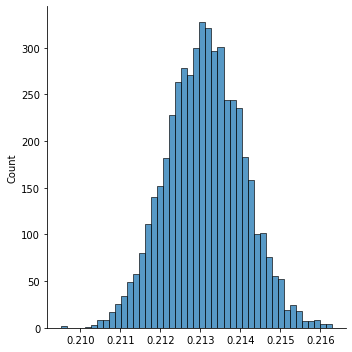

In [17]:
get_global_ctr(df[df.exp_group ==0])

[0.22833633629575367, 0.229905013535025, 0.23146901802143144]

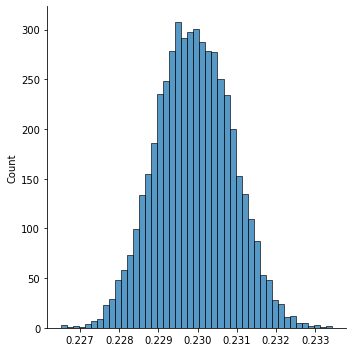

In [18]:
get_global_ctr(df[df.exp_group ==1])

In [19]:
#  Доверительные интервалы для Global CTR в группе 0 не пересекается с доверительным интервалом для Global CTR в группе 1,
# и средний Global CTR в контрольной группе больше, чем в тестовой группе, 
# что подтвержается вывод о том, что система рекомендаций работает. 

In [20]:
# Проведем контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей.

In [21]:
mean_views_0 = df[df.exp_group ==0].views.mean()
mean_views_0

61.297914903439256

In [22]:
mean_views_1 = df[df.exp_group ==1].views.mean()
mean_views_1

61.2005076142132

In [23]:
stats.ttest_ind(df[df.exp_group == 0].views, df[df.exp_group == 1].views,
                equal_var=False)

Ttest_indResult(statistic=0.18557426218615805, pvalue=0.8527800866422888)

In [24]:
stats.mannwhitneyu(df[df.exp_group == 0].views, df[df.exp_group ==1].views)

MannwhitneyuResult(statistic=84514942.0, pvalue=0.9717276363684261)

In [25]:
# p-value больше выбранного уровня значимости 0.05, поэтому мы принимаем нулевую гипотезу о равенстве количества просмотров в тестовой и контрольной группах. 
# То есть, изменения в системе рекомендаций не приводит к сокращению количества просмотров постов.

In [26]:
# Мы можем раскатывать новый алгоритм на всех новых пользователей, так как доказано увеличение СTR при неизменном количестве просмотров.